In [1]:
import pandas as pd
import torch
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [2]:
x_train_full = pd.read_csv("tesla data/TSLA training.csv")
x_test = pd.read_csv("tesla data/TSLA Testing.csv")

In [3]:
x_train_full.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-06-22,23.436001,23.483334,22.133333,22.242001,22.242001,153991500
1,2018-06-25,22.007999,22.564667,21.833332,22.200666,22.200666,103969500
2,2018-06-26,22.403334,22.903334,21.719999,22.799999,22.799999,111787500
3,2018-06-27,23.000000,23.386000,22.633333,22.966667,22.966667,125005500
4,2018-06-28,23.243999,23.801332,23.073999,23.328667,23.328667,125970000


In [4]:
x_train_full["Date"] = pd.to_datetime(x_train_full["Date"])
x_test["Date"] = pd.to_datetime(x_test["Date"])
x_train_full.set_index("Date", inplace = True)
x_test.set_index("Date", inplace = True)
x_train_full.sort_index(inplace = True)
x_test.sort_index(inplace = True)
cols = list(x_train_full.select_dtypes(include = np.float64))
x_train_full = x_train_full.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-06-22 to 2023-06-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1257 non-null   float32
 1   High       1257 non-null   float32
 2   Low        1257 non-null   float32
 3   Close      1257 non-null   float32
 4   Adj Close  1257 non-null   float32
 5   Volume     1257 non-null   float32
dtypes: float32(6)
memory usage: 39.3 KB


In [5]:
len(x_test)

251

In [6]:
x_train, x_valid = x_train_full[:-257], x_train_full[-257:]

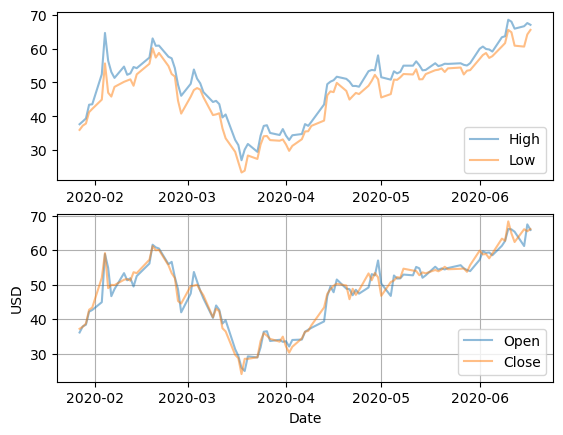

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
axs[0].plot(x_train[["High", "Low"]][400:500], alpha = 0.5)
axs[0].legend(["High", "Low"])
axs[1].plot(x_train[["Open", "Close"]][400:500], alpha = 0.5)
axs[1].legend(["Open", "Close"])
plt.xlabel("Date")
plt.ylabel("USD")
plt.grid()
plt.show()

<Axes: xlabel='Date'>

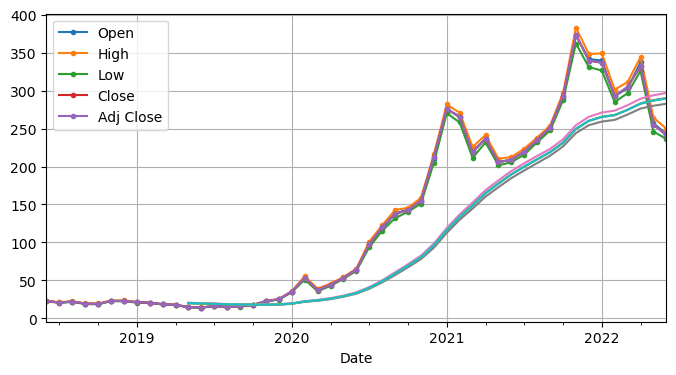

In [8]:
period = slice("2018", "2022")
df_monthly = x_train.drop("Volume", axis = 1).resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)

<Axes: xlabel='Date'>

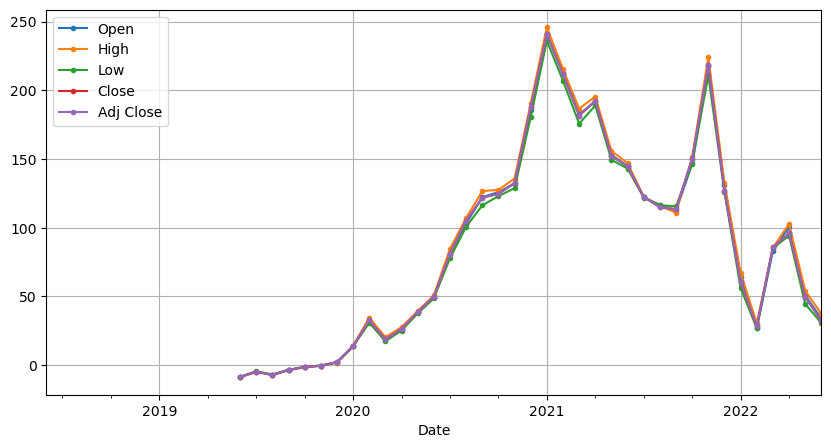

In [9]:
df_monthly.diff(12)[period].plot(grid = True, marker = ".", figsize = (10, 5))

In [10]:
x_train = x_train.apply(np.log)

<Axes: xlabel='Date'>

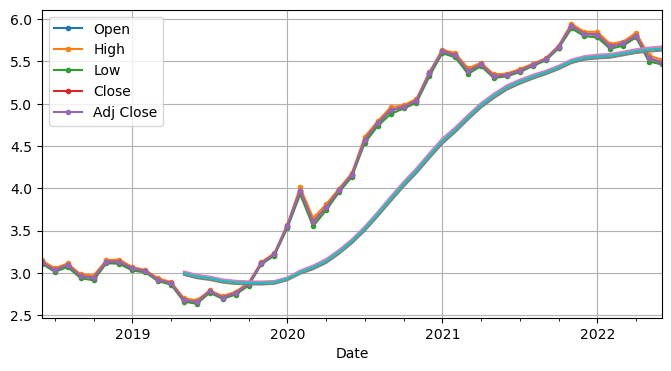

In [11]:
period = slice("2018", "2022")
df_monthly = x_train.drop("Volume", axis = 1).resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)

<Axes: xlabel='Date'>

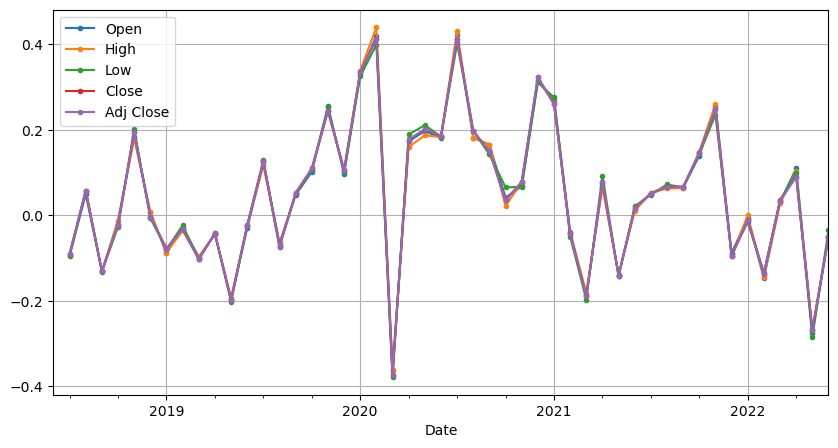

In [12]:
df_monthly.diff(1)[period].plot(grid = True, marker = ".", figsize = (10, 5))

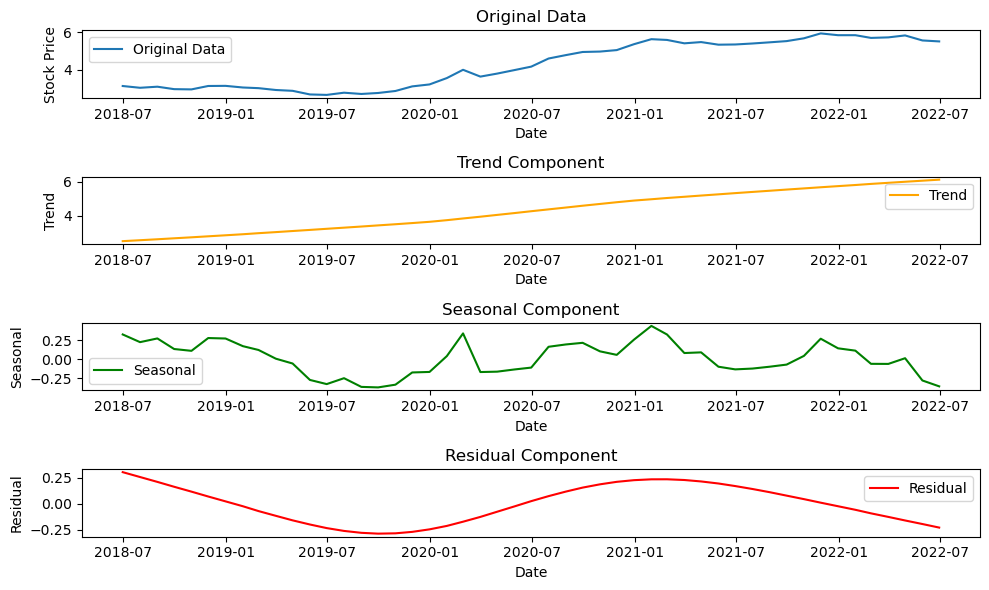

In [13]:
from statsmodels.tsa.seasonal import STL

stl_result = STL(df_monthly["High"], seasonal=3).fit()

trend = stl_result.trend
seasonal = stl_result.seasonal
residual = stl_result.resid

plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(df_monthly.index, df_monthly["High"], label='Original Data')
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df_monthly.index, trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df_monthly.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df_monthly.index, residual, label='Residual', color='red')
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()

plt.tight_layout()
plt.show()

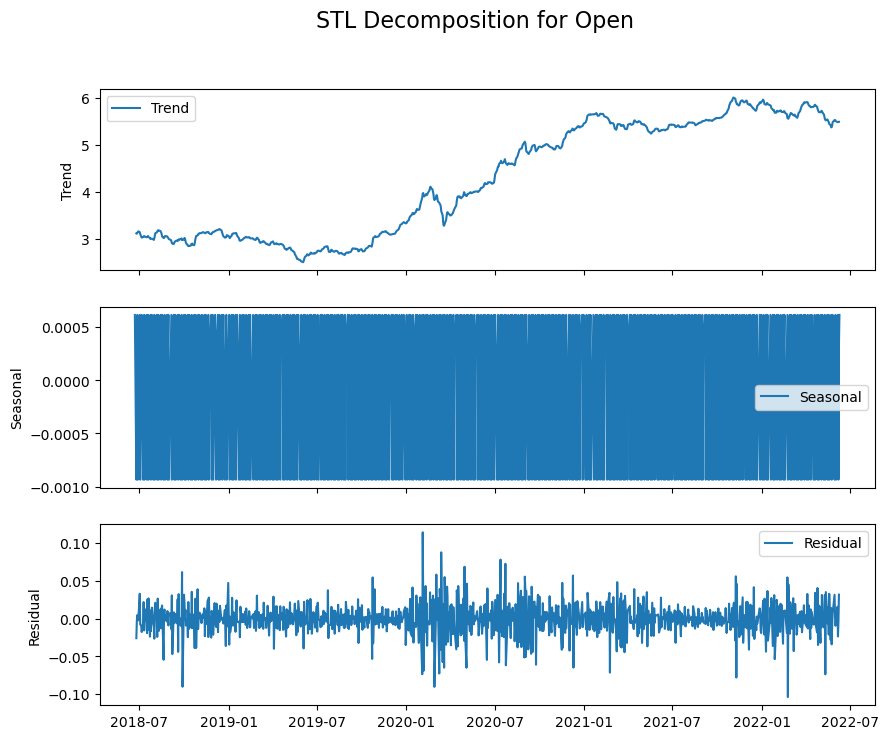

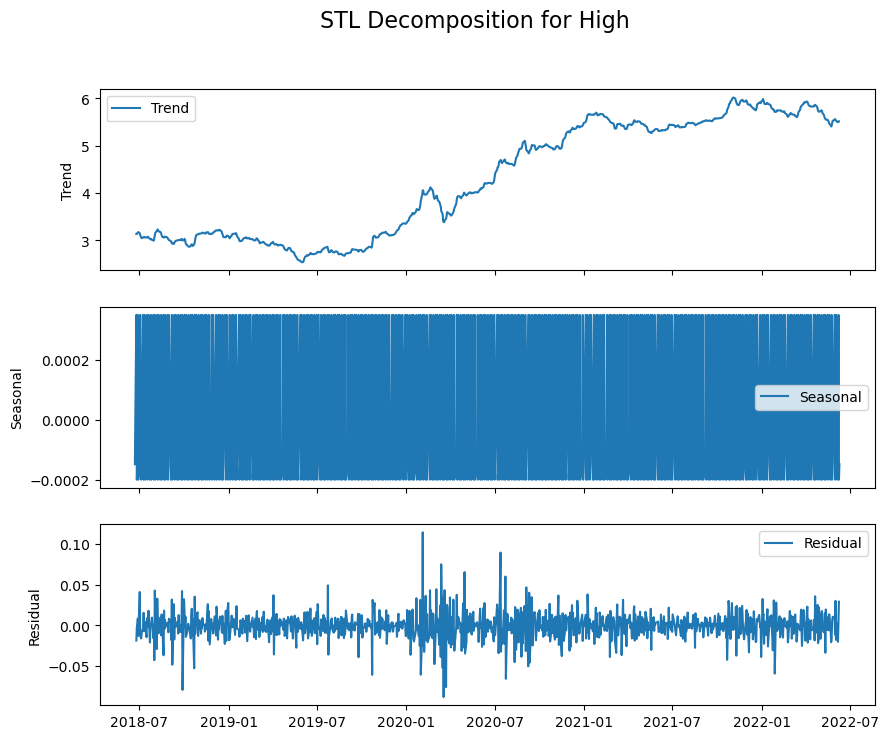

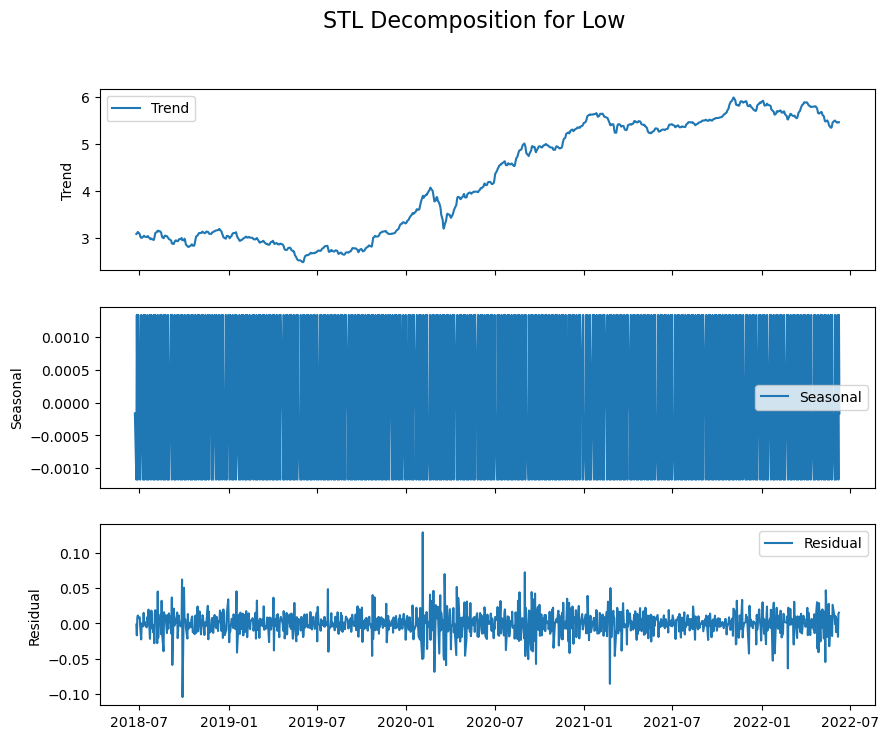

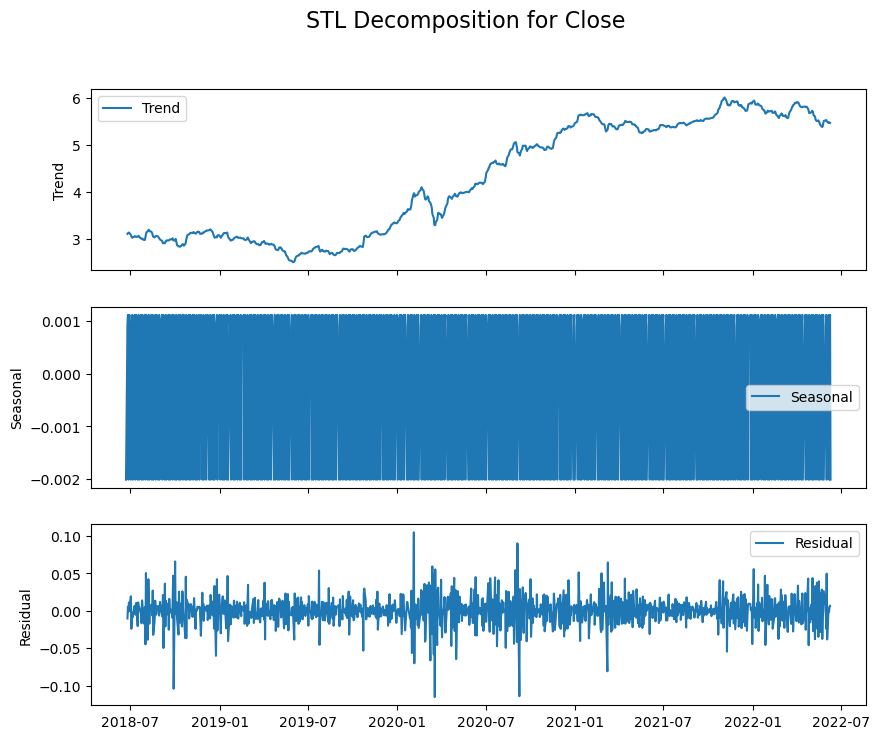

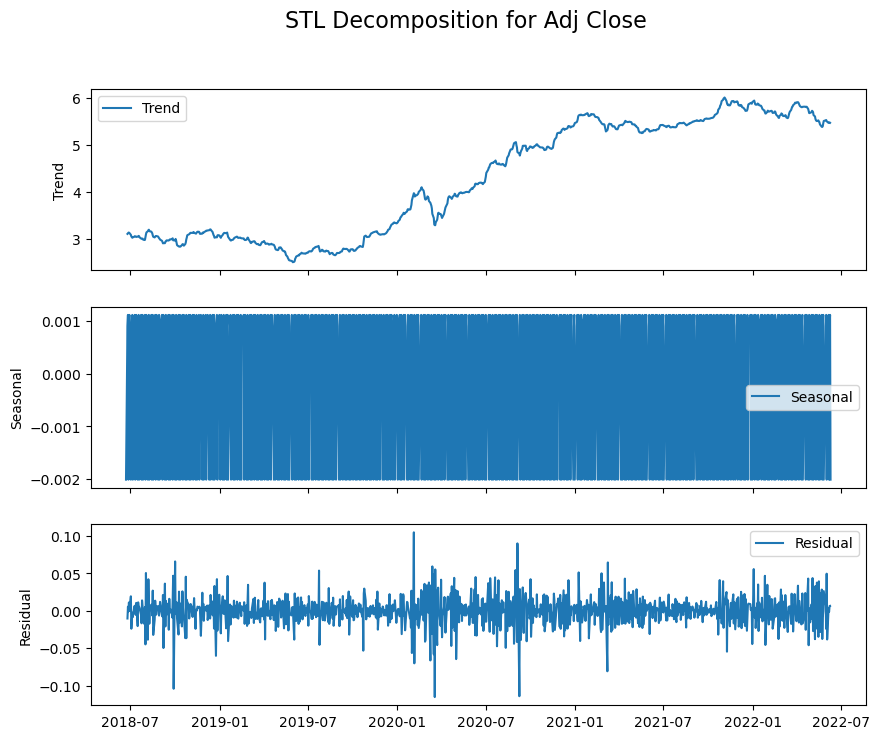

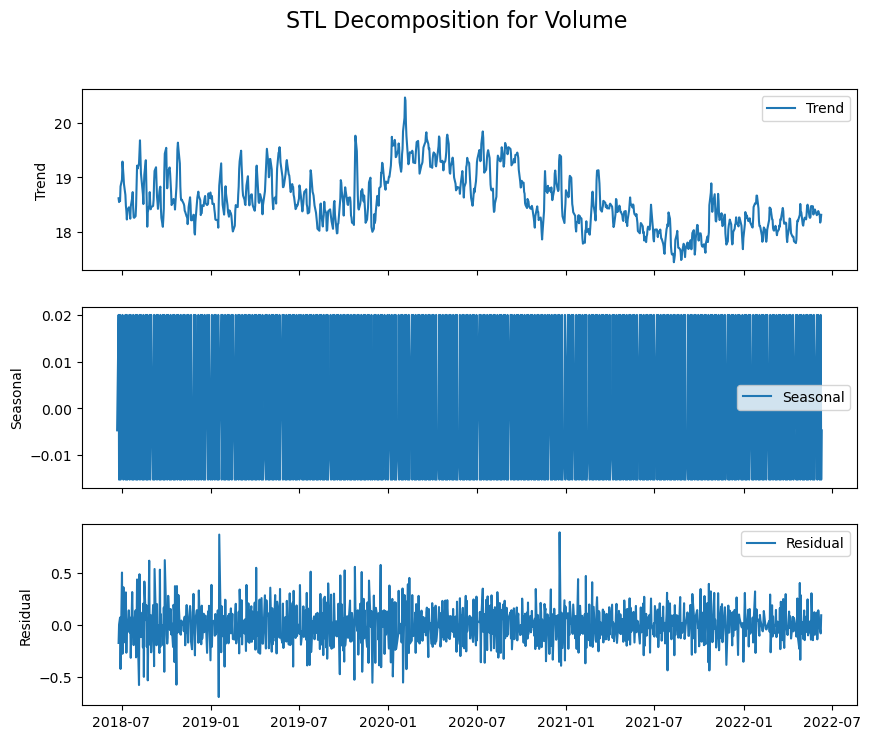

In [14]:
import pandas as pd
import statsmodels.api as sm

decomposition = {}
for col in x_train.columns:
    decomposition[col] = sm.tsa.seasonal_decompose(x_train[col], period=3)

for col in x_train.columns:
    trend_component = decomposition[col].trend
    seasonal_component = decomposition[col].seasonal
    residual_component = decomposition[col].resid
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'STL Decomposition for {col}', fontsize=16)

    axs[0].plot(trend_component.index, trend_component, label='Trend')
    axs[0].set_ylabel('Trend')
    
    axs[1].plot(seasonal_component.index, seasonal_component, label='Seasonal')
    axs[1].set_ylabel('Seasonal')

    axs[2].plot(residual_component.index, residual_component, label='Residual')
    axs[2].set_ylabel('Residual')

    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    plt.show()

deseasonalized_data = x_train - pd.DataFrame({col: decomposition[col].seasonal for col in x_train.columns})



In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
deseasonalized = scaler.fit_transform(deseasonalized_data).astype(np.float32)

In [16]:
def create_seqs(data, window_size, step):
    return torch.tensor(np.array([data[i:i + window_size] for i in range(0, len(data) - window_size, step)]))

In [17]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, input_seq):
        self.input_seq = input_seq[:-1]
        self.target_seq = input_seq[1:]
        
    def __len__(self):
        return len(self.input_seq)
    
    def __getitem__(self, idx):
        return self.input_seq[idx], self.target_seq[idx]

In [18]:
deseasonalized_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2018-06-22 to 2022-06-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1000 non-null   float64
 1   High       1000 non-null   float64
 2   Low        1000 non-null   float64
 3   Close      1000 non-null   float64
 4   Adj Close  1000 non-null   float64
 5   Volume     1000 non-null   float64
dtypes: float64(6)
memory usage: 54.7 KB


In [19]:
dataset = TimeSeriesDataset(create_seqs(deseasonalized, 14, 1))
dataloader = DataLoader(dataset, batch_size = 1, shuffle = False, pin_memory = True)

valid_data = TimeSeriesDataset(create_seqs(x_valid.apply(np.log).astype(np.float32), 14, 1))
valid_dataloader = DataLoader(valid_data, batch_size = 1, shuffle = False, pin_memory = True)

In [20]:
create_seqs(deseasonalized, 14, 1)[0][0]

tensor([-0.9324, -0.9477, -0.9612, -0.9747, -0.9747,  0.4765])

In [21]:
class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.LSTM1 = torch.nn.LSTM(6, 32, 3)
        self.regression = torch.nn.Sequential(
            torch.nn.Dropout(0.3),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 6)
            )
        
        
    def forward(self, x):
        x = x.view(14, 6)
        out, _ = self.LSTM1(x)
        out = self.regression(out)
        return out

In [22]:
model = RNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RNN(
  (LSTM1): LSTM(6, 32, num_layers=3)
  (regression): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [23]:
loss_fn = torch.nn.HuberLoss(delta = 0.9)
optimizer = torch.optim.NAdam(model.parameters(), lr = 0.001)

num_epochs = 30
for epoch in range(num_epochs):
    training_loss = 0
    valid_loss = 0
    model.train()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(-1))
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        training_loss += loss.data.item()
    training_loss /= len(dataloader.dataset)
    
    model.eval()
    for inputs, targets in valid_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs.unsqueeze(-1))
        loss = loss_fn(outputs, targets)
        valid_loss += loss.data.item()
    valid_loss /= len(valid_dataloader.dataset)
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss}, Valid Loss: {valid_loss}")

c:\python stuff\lib\site-packages\torch\nn\modules\loss.py:988: UserWarning: Using a target size (torch.Size([1, 14, 6])) that is different to the input size (torch.Size([14, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


Epoch [1/30], Loss: 0.05179352407263318, Valid Loss: 5.711160504128322
Epoch [2/30], Loss: 0.06094946156014797, Valid Loss: 5.683456245532706
Epoch [3/30], Loss: 0.060396550123480525, Valid Loss: 5.661041933642931
Epoch [4/30], Loss: 0.05920397308442345, Valid Loss: 5.7087704288072825
Epoch [5/30], Loss: 0.05542937627553864, Valid Loss: 5.675556125719686
Epoch [6/30], Loss: 0.05559631611225266, Valid Loss: 5.671756366067681
Epoch [7/30], Loss: 0.05655719565870571, Valid Loss: 5.657563278497744
Epoch [8/30], Loss: 0.06042654238792543, Valid Loss: 5.531259489453529
Epoch [9/30], Loss: 0.0539444409826118, Valid Loss: 5.578317003801835
Epoch [10/30], Loss: 0.05533802229911089, Valid Loss: 5.677365773965504
Epoch [11/30], Loss: 0.05859546015691485, Valid Loss: 5.56954662464867
Epoch [12/30], Loss: 0.05824665291764334, Valid Loss: 5.605228258558541
Epoch [13/30], Loss: 0.05684701747776288, Valid Loss: 5.238002554444242
Epoch [14/30], Loss: 0.056039943852400416, Valid Loss: 5.454269145145889
